In [1]:
import json
import numpy as np
import os
from tqdm import tqdm

# Initialize containers for energies
methods = ["opt", "HF", "B3LYP", "sto-3G","basisNN"]
energy_data = {method: [] for method in methods}

# Load the JSON file
file_path = "inference.json"
with open(file_path, "r") as file:
    data = json.load(file)

eigenvalue_l = []
name_l = np.array(data["name"])
print(name_l)
print(len(data["proj"]))
for i in range(len(data["proj"])):
    # Extract the first matrix under the 'proj' key
    i_matrix = np.array(data["proj"][i])

    # Compute the eigenvalues
    eigenvalues = np.linalg.eigvals(i_matrix)
    eigenvalues.sort()
    eigenvalue_l.extend(eigenvalues)
print(len(eigenvalue_l))

['19.json' '18.json' '17.json' '16.json' '15.json' '14.json' '13.json'
 '12.json' '11.json' '10.json' '0.json' '6.json' '1.json' '7.json'
 '2.json' '8.json' '3.json' '9.json' '4.json' '5.json' '22.json' '21.json'
 '20.json']
23
690


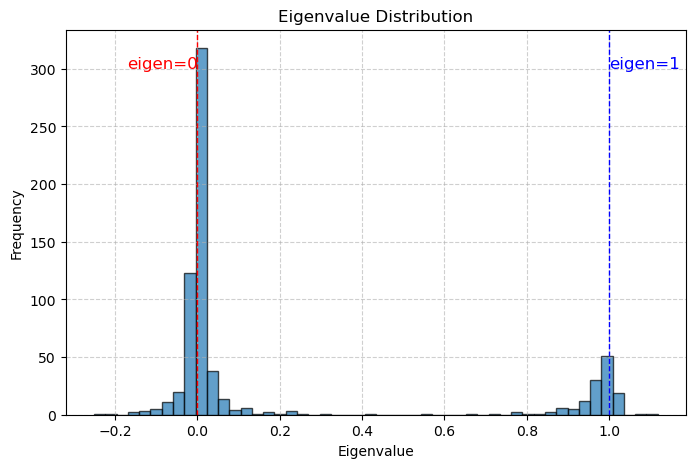

In [2]:
import matplotlib.pyplot as plt

def plot_distribution(eigenvalue_l, bins=50):
    plt.figure(figsize=(8, 5))
    plt.hist(eigenvalue_l, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add vertical dashed lines
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
    
    # Add text labels
    plt.text(0, plt.ylim()[1] * 0.9, 'eigen=0', color='red', ha='right', fontsize=12)
    plt.text(1, plt.ylim()[1] * 0.9, 'eigen=1', color='blue', ha='left', fontsize=12)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Distribution')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
plot_distribution(eigenvalue_l)


In [3]:
from downfolding_methods_pytorch import nelec, norbs, fock_downfolding, Solve_fermionHam, perm_orca2pyscf
from pyscf import gto, scf, dft
import scipy

def calc_basisNN_inp_file(inp_data):
    elements = inp_data['elements']
    coordinates = inp_data['coordinates']
    atoms = [(elements[i], coordinates[i]) for i in range(len(elements))]
    S = gto.M(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    ).intor("int1e_ovlp")
    sqrtS = scipy.linalg.sqrtm(S).real
    perm = perm_orca2pyscf(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    )
    
    proj = inp_data['proj']
    proj = perm @ proj @ perm.T
    proj = sqrtS @ proj @ sqrtS
    
    n_fold = norbs(atom=atoms,basis='sto-3g')
    ham = fock_downfolding(n_fold,('self-defined',-proj),False,atom=atoms, basis='cc-pVDZ')
    E = Solve_fermionHam(ham.Ham_const, ham.int_1bd, ham.int_2bd, nele=nelec(atom=atoms, basis='sto-3G'), method='FCI')[0]
    return E

print(len(data["proj"]))


with tqdm(total=len(data["proj"]), desc="Processing", dynamic_ncols=True) as pbar:
    for proj, elements, pos in zip(data["proj"], data["elements"], data["pos"]):
        inp_data = {'elements': elements, 'coordinates': pos, 'proj': proj}
        basisNN_E = calc_basisNN_inp_file(inp_data)
        energy_data['basisNN'].append(basisNN_E)
        
        pbar.set_postfix({"basisNN_E": f"{basisNN_E:.6f}"})  # Format to 6 decimals for better readability
        pbar.update(1)

23


Processing: 100%|██████████| 23/23 [00:19<00:00,  1.17it/s, basisNN_E=-3.012668]


In [4]:
folder = "/global/homes/w/whe1/ML-LinearSpace/dataset/H6_diss"
# collect other energies
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    energy_data['opt'].append(data['opt_E'])
    energy_data['HF'].append(data['HF_E'])
    energy_data['B3LYP'].append(data['B3LYP_E'])
    energy_data['sto-3G'].append(data['sto-3G_E'])


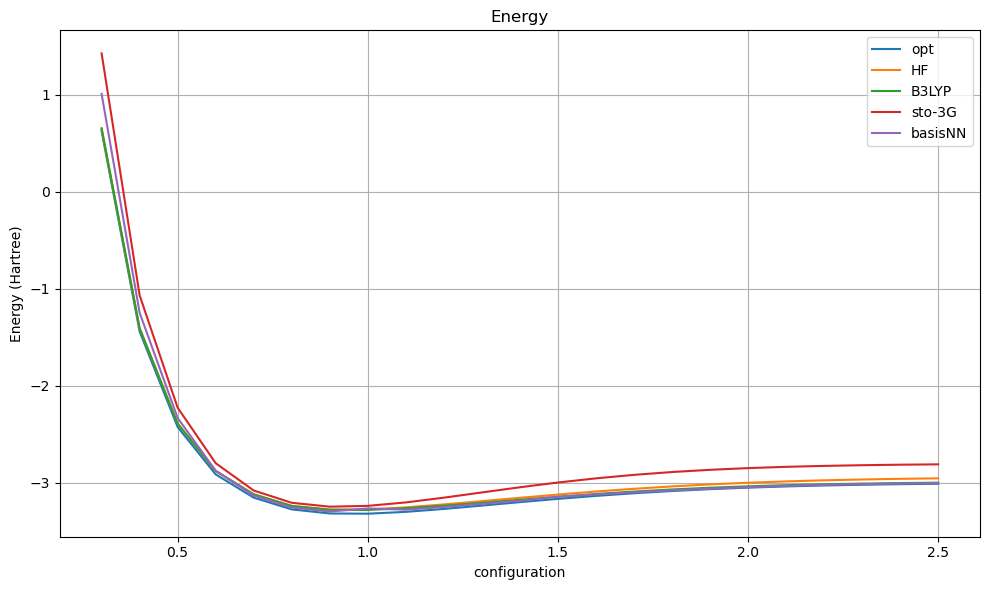

Figure saved as energy_distribution_smooth.png


In [5]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = []
for point in range(3, num_chains + 1):
    bond_length = bond_length_interval * point
    lengths.append(bond_length)


# Plot the frequency distribution for each method using KDE
plt.figure(figsize=(10, 6))

numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

for method in methods:
    if energy_data[method]:  # Ensure there's data to plot
        plt.plot(lengths, np.array(energy_data[method])[sorted_indices], label=method)

# Configure the plot
plt.title("Energy")
plt.xlabel("configuration")
plt.ylabel("Energy (Hartree)")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_distribution_smooth.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")

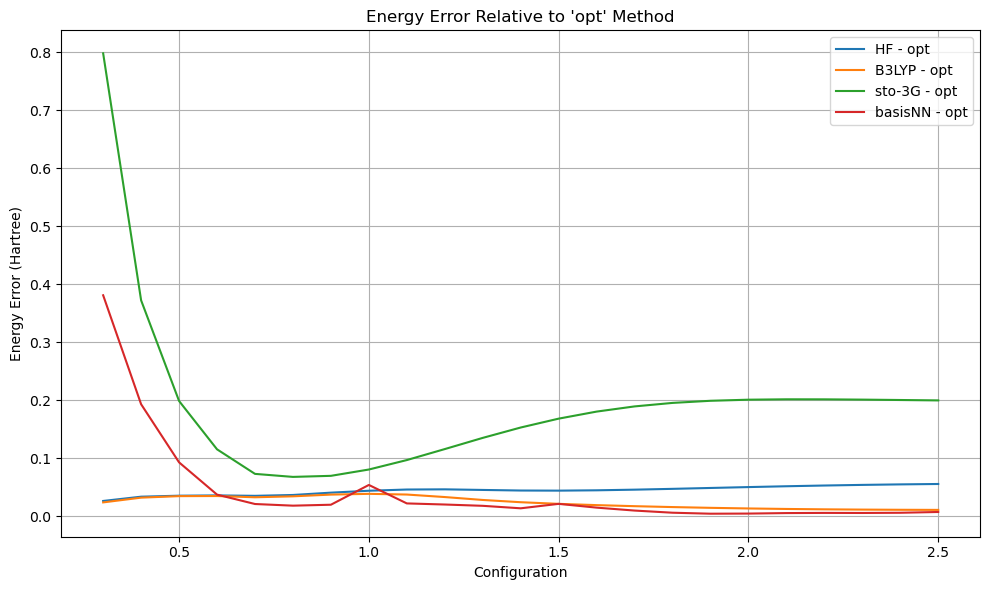

Figure saved as energy_error_plot.png


In [6]:


# Get baseline energy values
baseline_energy = np.array(energy_data['opt'])[sorted_indices]

plt.figure(figsize=(10, 6))



# Plot error of other methods relative to 'opt'
for method in methods:
    if method != 'opt' and energy_data[method]:  # Ensure there's data to plot
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        plt.plot(lengths,error, label=f"{method} - opt")

# Configure the plot
plt.title("Energy Error Relative to 'opt' Method")
plt.xlabel("Configuration")
plt.ylabel("Energy Error (Hartree)")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_error_plot.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")


/tmp/ipykernel_1905870/2036035269.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


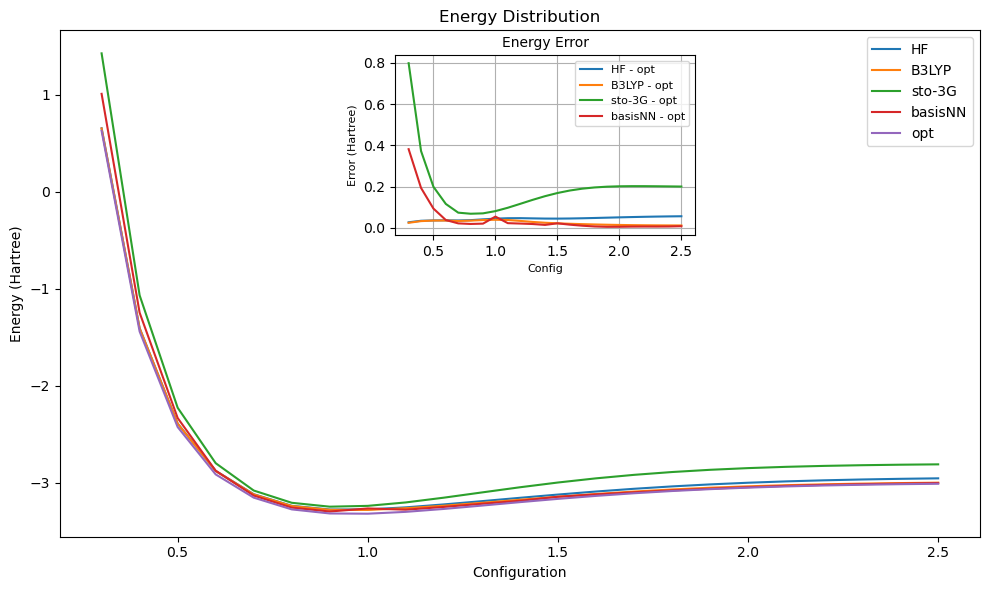

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = []
for point in range(3, num_chains + 1):
    bond_length = bond_length_interval * point
    lengths.append(bond_length)

# Assume `methods`, `energy_data`, and `name_l` are defined elsewhere
numeric_values = np.array([int(name.split('.')[0]) for name in name_l])
sorted_indices = np.argsort(numeric_values)

# Create main figure
fig, ax_main = plt.subplots(figsize=(10, 6))

# Plot main figure (Energy distribution)
for method in methods:
    if  method != 'opt' and energy_data[method]:  # Ensure there's data to plot
        ax_main.plot(lengths, np.array(energy_data[method])[sorted_indices], label=method)
ax_main.plot(lengths, np.array(energy_data['opt'])[sorted_indices], label='opt')

ax_main.set_title("Energy Distribution")
ax_main.set_xlabel("Configuration")
ax_main.set_ylabel("Energy (Hartree)")
ax_main.legend(loc="best")
ax_main.grid(False)

# Create an inset axes
ax_inset = fig.add_axes([0.4, 0.6, 0.3, 0.3])  # Adjust inset position and size

# Get baseline energy values
baseline_energy = np.array(energy_data['opt'])[sorted_indices]

# Plot error relative to 'opt' inside inset
for method in methods:
    if method != 'opt' and energy_data[method]:  # Ensure there's data to plot
        error = np.array(energy_data[method])[sorted_indices] - baseline_energy
        ax_inset.plot(lengths, error, label=f"{method} - opt")

ax_inset.set_title("Energy Error", fontsize=10)
ax_inset.set_xlabel("Config", fontsize=8)
ax_inset.set_ylabel("Error (Hartree)", fontsize=8)
ax_inset.legend(fontsize=8)
ax_inset.grid(True)

# Save and show the plot
plt.tight_layout()
plt.show()
plt.close()
